# Practice: gym interface and crossentropy method

_Reference:_ This notebook is based on Practical RL [week01](https://github.com/yandexdataschool/Practical_RL/tree/master/week01_intro)

In [1]:
!pip install -r requirements.txt

In [2]:
import gymnasium as gym
print(gym.__version__)

import numpy as np
import matplotlib.pyplot as plt

# from IPython import display
from IPython.display import clear_output, display

1.1.1


## OpenAI Gym

Следующие несколько недель мы потратим на изучение алгоритмов, которые помогают в процессе принятия решений. Затем нам понадобится несколько интересных задач для тестирования наших алгоритмов.

Вот тут-то и вступает в игру OpenAI Gym. Это библиотека Python, которая охватывает множество классических задач, связанных с принятием решений, включая управление роботами, видеоигры и настольные игры.

Рассмотрим среду [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

Итак, вот как это работает:

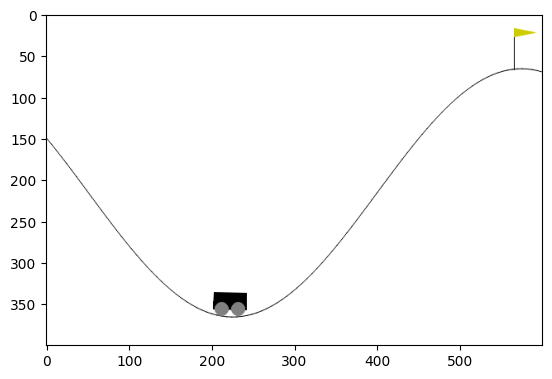

Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


In [3]:
env = gym.make("MountainCar-v0", render_mode='rgb_array')
env.reset()

env_screen = env.render()
plt.imshow(env_screen)
plt.show()

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)



### Gym interface

Существуют три основных метода настройки среды:
* `reset()`: возвращает среду в исходное состояние и _return (возвращает ее обратно)_
* `render()`: показывает текущее состояние среды (более красочная версия).
* `step(a)`: совершаем действие "a" и возвращаем "(new_state, вознаграждение, is_done, информация)"
  * `new_state`: новое состояние сразу после совершения действия "a".
  * `reward`: число, представляющее вашу награду за совершение действия "a"
  * `is_done`: значение True, если MDP только что завершился, и значение False, если все еще продолжается
  * `info`: некоторые дополнительные сведения о том, что только что произошло. Пока не обращайте на это внимания.

In [4]:
state = env.reset()
print("initial state:", state)

initial state: (array([-0.57040524,  0.        ], dtype=float32), {})


В горной машине наблюдение - это всего лишь две цифры: положение автомобиля и скорость.

Давайте выполним действие 2, которое расшифровывается как "поверни направо".

In [5]:
print("taking action 2 (right)")
new_state, reward, is_done, truncated, _ = env.step(2)

print("new state:", new_state)
print("reward:", reward)
print("is game over?:", is_done)
print("is game truncated due to time limit?:", is_done)

taking action 2 (right)
new state: [-0.5690553  0.0013499]
reward: -1.0
is game over?: False
is game truncated due to time limit?: False


### Play with it

Ниже приведен код, который ускоряет автомобиль вправо. Однако, если вы просто используете политику по умолчанию, автомобиль не достигнет крайнего правого флажка из-за силы тяжести.

__Ваша задача__ - исправить это. Найдите стратегию, которая позволит добраться до флага.

На данный момент от вас не требуется создавать какие-либо сложные алгоритмы, и вам определенно не нужно знать какие-либо методы обучения с подкреплением для этого. Не стесняйтесь использовать жесткий код :)

In [6]:
TIME_LIMIT = 250
env = gym.wrappers.TimeLimit(
    gym.make("MountainCar-v0", render_mode="rgb_array"),
    max_episode_steps=TIME_LIMIT + 1,
)

actions = {"left": 0, "stop": 1, "right": 2}

In [7]:
def policy(obs, t):
    position, velocity = obs
    return actions["right"]

KeyboardInterrupt: 

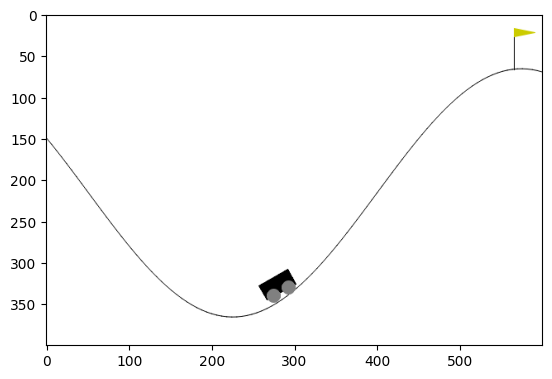

In [11]:
clear_output(wait=True)

obs, _ = env.reset()
for t in range(TIME_LIMIT):
    plt.gca().clear()

    action = policy(obs, t)  # Call your policy
    obs, reward, terminated, truncated, _ = env.step(
        action
    )  # Pass the action chosen by the policy to the environment

    # We don't do anything with reward here because MountainCar is a very simple environment,
    # and reward is a constant -1. Therefore, your goal is to end the episode as quickly as possible.

    # Draw game image on display.
    plt.imshow(env.render())

    display(plt.gcf())
    clear_output(wait=True)

    if terminated or truncated:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

clear_output(wait=True)

In [12]:
def policy(state, time_step):
    # Write the code for your policy here. You can use the current state
    # (a tuple of position and velocity), the current time step, or both,
    # if you want.
    position, velocity = state

    # Ваш код здесь
    if velocity > 0.001:
        return actions["right"]

    elif velocity < -0.001:
        return actions["left"]

    else:
        return actions["stop"]

Well done!


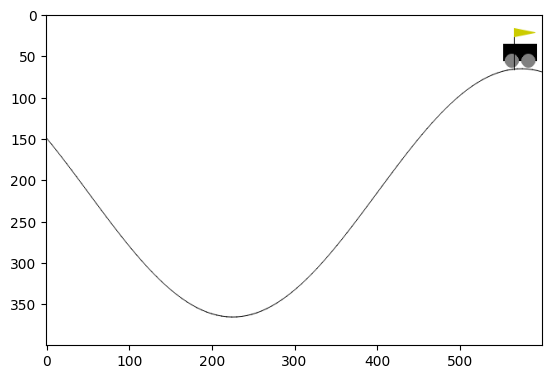

In [13]:
is_done = 0

state, _ = env.reset()
for time_step in range(TIME_LIMIT):
    plt.gca().clear()
    # Choose action based on your policy.

    # Pass the action to the environment.

    # We don't do anything with reward here because MountainCar is a very
    # simple environment, and reward is a constant -1 (meaning that your
    # goal is to end the episode as quickly as possible).
    action = policy(state, time_step)
    state, reward, is_done, truncated, _ = env.step(action)

    # Draw game image on display.

    plt.imshow(env.render())
    # plt.show()

    display(plt.gcf())
    clear_output(wait=True)

    if is_done:
          print("Well done!")
          break
if not is_done:
    print("Time limit exceeded. Try again.")

## Crossentropy method

Теперь, когда мы знаем, как работает `gym`, давайте попробуем решить более сложную задачу, используя метод перекрестной энтропии.

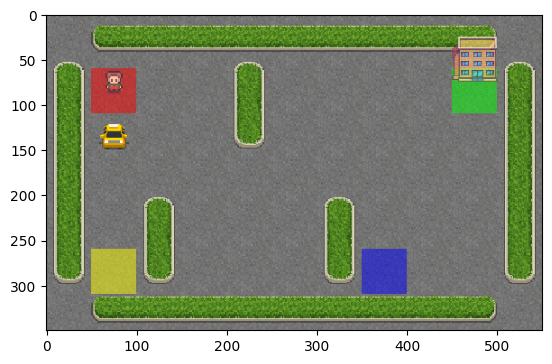

In [14]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())


Поскольку [`Taxi-v3`](https://gymnasium.farama.org/environments/toy_text/taxi/) представляет собой гораздо более сложную среду, в нашем распоряжении оказывается больше возможных состояний и действий.

In [15]:
n_states, n_actions = env.observation_space.n, env.action_space.n
print(f"n_states={n_states}, n_actions={n_actions}")

n_states=500, n_actions=6


Это определенно много. Слишком много для жесткого программирования, как мы делали с предыдущей задачей. Давайте используем метод перекрестной энтропии для решения этой задачи.

### Create stochastic policy

На этот раз нашей политикой должно быть распределение вероятностей.

`policy[s, a] = P(выполнить действие a | в состоянии s)`

Поскольку мы по-прежнему используем целочисленные представления состояния и действия, вы можете использовать двумерный массив для представления политики.

Пожалуйста, инициализируйте политику __единообразно__, то есть вероятности всех действий должны быть равны.

In [16]:
def initialize_policy(n_states, n_actions):
    # Create an array to store action probabilities

    # Ваш код здесь
    policy = np.full([n_states, n_actions], 1 / n_actions)

    return policy

In [17]:
policy = initialize_policy(n_states, n_actions)

assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1.0 / n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

print("All done!")

All done!


### Play the game

Давайте поиграем в игру, как и раньше, однако на этот раз мы также будем записывать состояния, действия и награды, чтобы использовать их в цикле тренировок.

In [18]:
env.step(1)

(1,
 -1,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 1, 0], dtype=int8)})

In [19]:
def generate_session(env, policy, time_limit=10**4):
    state, _ = env.reset()
    states, actions = [], []
    total_reward = 0.

    for _ in range(time_limit):
        # Choose action based on policy and take it.
        # Ваш код здесь
        action = np.random.choice(n_actions, p=policy[state])
        new_state, reward, is_done, truncated, _ = env.step(action)
        # Record information we just got from the environment.
        # Ваш код здесь
        states.append(state)
        actions.append(action)
        total_reward += reward

        state = new_state
        if is_done:
            break

    return states, actions, total_reward

In [20]:
states, actions, reward = generate_session(env, policy)

Давайте посмотрим на первоначальное распределение вознаграждений за нашу "наивную" политику.

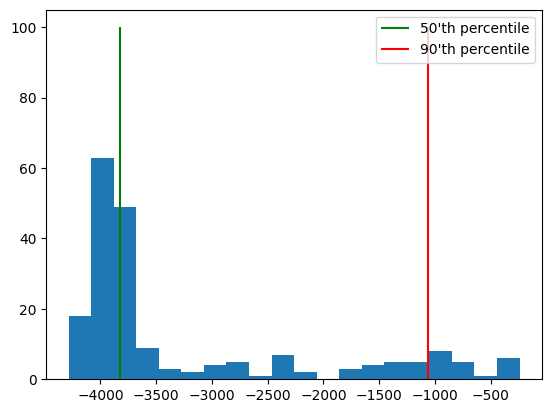

In [21]:
sample_rewards = [generate_session(env, policy, time_limit=1000)[2] for _ in range(200)]
plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color="green")
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color="red")
plt.legend();

In [22]:
np.percentile(sample_rewards, 90)

-1061.2

### Crossentropy method step

In [23]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile.

    Compute minimum reward for session to be elite and choose elite states
    and actions based on this threshold.

    Note that states_batch and actions_batch are both 2d lists, i.e. lists
    containing lists of states and actions from each session in batch.
    """

    elite_states = []
    elite_actions = []
    # Ваш код здесь
    reward_threshold = np.percentile(rewards_batch, percentile)
    for session_states, session_actions, session_reward in zip(states_batch, actions_batch, rewards_batch):
        # If session is not elite - skip it
        if session_reward < reward_threshold:
            continue
        elite_actions.extend(session_actions)
        elite_states.extend(session_states)

    return elite_states, elite_actions

In [24]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites, return a new
    policy where each action probability is proportional to

        policy[s, a] ~ #[occurrences of s and a in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities.
    For states that you never visited, use a uniform distribution.
    """

    new_policy = np.zeros([n_states, n_actions])

    # Set probabilities for actions given elite states & actions.
    # Ваш код здесь
    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1

    new_policy[np.where(np.sum(new_policy, axis=1) < 1), :] = 1
    new_policy /= np.sum(new_policy, axis=1, keepdims=True)


    return new_policy

### Training loop

Generate sessions, select N best and fit to those.

In [25]:
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)

    mean_rewards = [mean_reward for mean_reward, threshold in log]
    reward_thresholds = [threshold for mean_reward, threshold in log]
    plt.plot(mean_rewards, label="Mean rewards")
    plt.plot(reward_thresholds, label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        ymin=[0],
        ymax=[100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(wait=True)
    print(f"mean reward = {mean_reward:.3f}, threshold={threshold:.3f}")
    plt.show()

In [26]:
# reset policy
policy = initialize_policy(n_states, n_actions)

mean reward = -1116.752, threshold=8.000


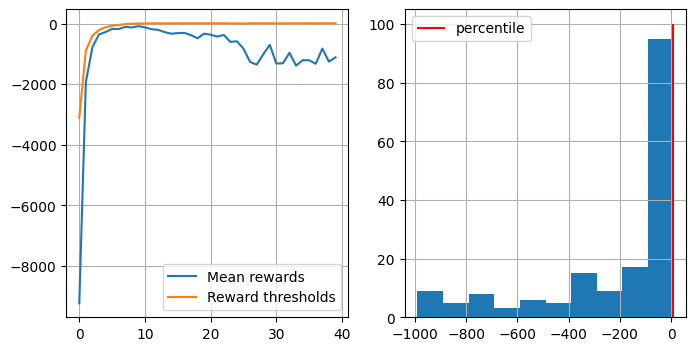

In [27]:
epochs = 40
n_sessions = 250     # sample this many sessions
percentile = 70      # take this percent of session with highest rewards
learning_rate = 0.8  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in range(epochs):
    # Generate a list of n_sessions new sessions, select elites and compute
    # new policy based on them. After that update the existing policy wrt
    # learning rate.
    sessions = [generate_session(env, policy)  for _ in range(n_sessions)]
    states_batch = [session_states for session_states, session_actions, session_reward in  sessions]
    actions_batch = [session_actions for session_states, session_actions, session_reward in  sessions]
    rewards_batch = [session_reward for session_states, session_actions, session_reward in  sessions]

    # Ваш код здесь
    elite_states, elite_actions = select_elites(
        states_batch, actions_batch, rewards_batch, percentile
    )
    new_policy = get_new_policy(elite_states, elite_actions)
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

### Анализ результатов

Возможно, вы заметили, что проблема с такси быстро переходит от очень низких значений к почти оптимальным, а затем возвращается обратно. Это вызвано (по крайней мере, частично) врожденной случайностью окружающей среды. А именно, исходные точки взаимодействия пассажира и водителя меняются от эпизода к эпизоду.

В таком случае, если кроссэнтропийная политика не смогла научиться побеждать с одной четкой отправной точки, она просто откажется от нее, потому что никакие занятия с этой отправной точки не приведут ее в "элиту".

Чтобы смягчить эту проблему, вы можете либо снизить порог для элитных сессий (метод клейкой ленты), либо изменить способ оценки стратегии (теоретически правильный способ). Для каждого начального состояния вы можете выбрать действие случайным образом, а затем оценить это действие, запустив несколько игр, начиная с него, и усреднив общую награду. Выбор элитных сессий с такой выборкой (где вознаграждение за каждую сессию рассчитывается как среднее значение вознаграждений за все сессии с одинаковым начальным состоянием и действием) должен повысить эффективность вашей политики.

## Копаем глубже: приблизительная кроссэнтропия с помощью нейронных сетей

В этом разделе мы расширим вашу реализацию CEM с помощью нейронных сетей! Вы обучите многослойную нейронную сеть решать простые игры с непрерывным пространством состояний.

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)

Рассмотрим среду [CartPole-v1](https://gymnasium.farama.org/main/environments/classic_control/cart_pole/)

state vector dim = 4
n_actions = 2


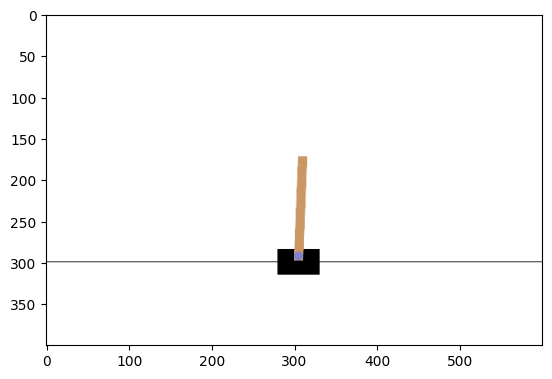

In [28]:
# .env is to remove auto-assigned time limit wrapper
env = gym.make("CartPole-v1", render_mode='rgb_array').env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

print("state vector dim =", state_dim)
print("n_actions =", n_actions)

plt.imshow(np.array(env.render()).squeeze())
plt.show()

In [29]:
env.reset() # координата и скорость тележки, угол и угловая скорость маятника (с точностью до перестановки внутри массива...)

(array([ 0.02615609,  0.0451027 ,  0.02473513, -0.03092385], dtype=float32),
 {})

Здесь, как и в ```MountainCar-v0```, мы будем управлять тележкой, которую мы можем перемещать вправо или влево. Однако наша цель здесь иная. В этой среде мы хотим как можно дольше удерживать шест, прикрепленный к верхней части нашей тележки, от падения.

### Neural Network Policy

Для этого задания мы будем использовать упрощенную реализацию нейронной сети из [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). Вот что вам понадобится:
* `agent.partial_fit(states, actions)` - выполняет однократный тренировочный проход по данным, чтобы увеличить вероятность выполнения заданных "actions" в заданных "states".
* `agent.predict_proba(states)` - предсказывает вероятности всех действий, используя матрицу вида `[len(states), n_actions] `

In [30]:
from sklearn.neural_network import MLPClassifier

In [31]:
[env.reset()] * n_actions

[(array([ 0.03528835,  0.00713424,  0.04966421, -0.00984902], dtype=float32),
  {}),
 (array([ 0.03528835,  0.00713424,  0.04966421, -0.00984902], dtype=float32),
  {})]

In [32]:
n_actions

2

In [33]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
    warm_start=True,
    max_iter=1
)

# initialize agent to the dimension of state space and number of actions
agent.fit([env.reset()[0]] * n_actions, range(n_actions))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20), max_iter=1,
              warm_start=True)

In [34]:
agent.predict_proba([env.reset()[0]]).squeeze()

array([0.64884951, 0.35115049])

Несмотря на очевидные различия, вы обнаружите, что процедура обучения для такого агента очень похожа на ту, которую мы использовали в предыдущей части. Нам даже не нужно будет переписывать большинство наших вспомогательных функций! Однако кое-что изменилось - это способ получения вероятностей действий. Итак, давайте адаптируем нашу функцию `generate_session` к этой новой политике, основанной на агентах.

In [35]:
def generate_session(env, agent, time_limit=10**4, test=False):
    if test:
      state = env.reset()
    else:
      state, _ = env.reset()
    states, actions = [], []
    total_reward = 0.
    for _ in range(time_limit):
        # Use agent to predict a vector of action probabilities for current
        # state and use the probabilities you predicted to pick an action.
        # Sample actions, don't just take the most likely one!

        # Ваш код здесь
        action_prob = agent.predict_proba([state]).squeeze()
        action = np.random.choice(n_actions, p=action_prob)

        states.append(state)
        actions.append(action)

        if test:
          state, reward, is_done, truncated = env.step(action)
        else:
          state, reward, is_done, truncated, _ = env.step(action)
        total_reward += reward

        # Record information we just got from the environment.
        if is_done:
            break

    return states, actions, total_reward

In [36]:
states, actions, reward = generate_session(env, agent, time_limit=100)
print("states:", np.stack(states))
print("actions:", actions)
print("reward:", reward)

states: [[ 0.00176454  0.00592091  0.04560871  0.00635027]
 [ 0.00188296 -0.18982446  0.04573571  0.3130673 ]
 [-0.00191353 -0.3855671   0.05199706  0.6198158 ]
 [-0.00962487 -0.58137524  0.06439337  0.9284113 ]
 [-0.02125238 -0.77730465  0.0829616   1.2406149 ]
 [-0.03679847 -0.58334005  0.1077739   0.97503144]
 [-0.04846527 -0.77972966  0.12727453  1.299531  ]
 [-0.06405987 -0.97621655  0.15326515  1.6291951 ]
 [-0.0835842  -0.7831922   0.18584904  1.3879362 ]]
actions: [0, 0, 0, 0, 1, 0, 0, 1, 1]
reward: 9.0


### Training loop

mean reward = 203.810, threshold=228.000


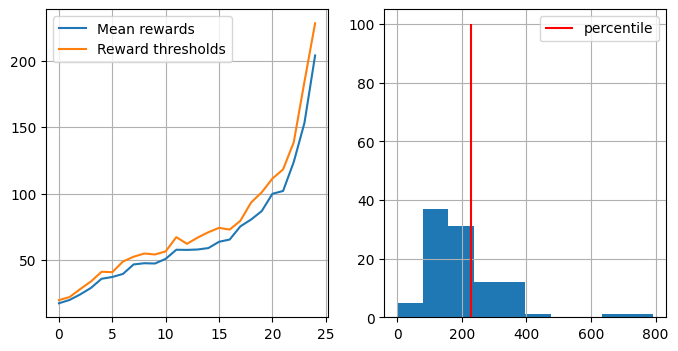

You Win! You may stop training now via KeyboardInterrupt.


In [37]:
n_sessions = 100
percentile = 70

log = []

for _ in range(100):
    # Generate new sessions, select elites and update our agent.

    sessions = [generate_session(env, agent)  for _ in range(n_sessions)]
    states_batch = [session_states for session_states, session_actions, session_reward in  sessions]
    actions_batch = [session_actions for session_states, session_actions, session_reward in  sessions]
    rewards_batch = [session_reward for session_states, session_actions, session_reward in  sessions]

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    # Ваш код здесь
    agent.fit(elite_states, elite_actions)

    show_progress(
        rewards_batch,
        log,
        percentile,
        reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

### Analysing the results

In [48]:
import gym.wrappers

with gym.wrappers.RecordVideo(
    gym.make("CartPole-v1", render_mode='rgb_array').env,
    video_folder="videos",
    episode_trigger=lambda x: True
    ) as env_monitor:
    generate_session(env_monitor, agent, test=True)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [49]:
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([file for file in Path("videos").iterdir() if file.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))